In [1]:
%matplotlib inline
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (16, 9)

# Assignment 2

## 1. Image Stitching 

This problem will walk you through the process of image stitching by detecting and matching corners, and estimating the homography based matches.

### 1a. Detect Keypoints and Calculate Descriptors (10 points)

Load the sample image pair.

In [2]:
img1 = cv2.imread('graff1.png')
img2 = cv2.imread('graff2.png')

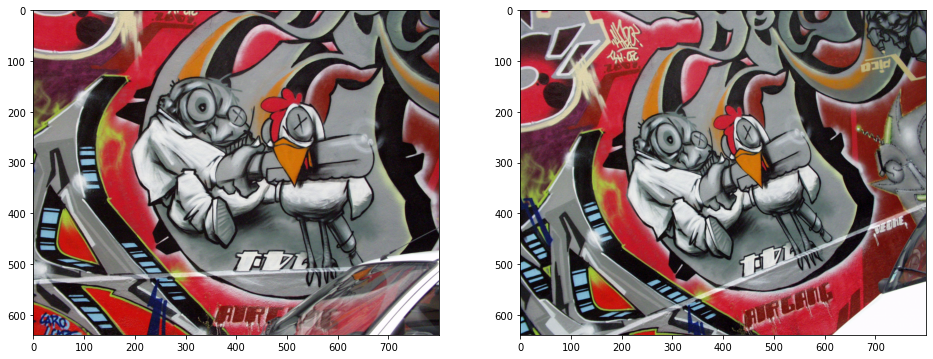

In [3]:
fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB))
plt.show()

Since we have implemented the Harris corner detector from scratch in the weekly notebooks, in this problem we will use OpenCV to detect corners and get their descriptors. In the cell below, detect feature points and calculate their descriptors in both images using OpenCV's ORB detector and descriptor.

In [4]:
# Initiate ORB detector
orb1 = cv2.ORB_create()
# find the keypoints with ORB
kp1 = orb1.detect(img1,None)

# Initiate ORB detector
orb2 = cv2.ORB_create()
# find the keypoints with ORB
kp2 = orb2.detect(img2,None)

kps1, des1 = orb1.compute(img1, kp1)
kps2, des2 = orb2.compute(img2, kp2)

Visualize locations of detected features. You should see the following images (also 1.png):

![image.png](attachment:image.png)


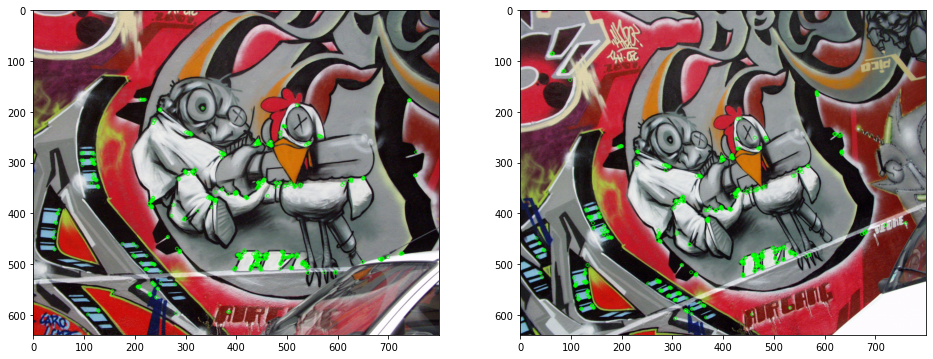

In [5]:
kp_img1 = cv2.drawKeypoints(img1, kps1, None, color=(0,255,0))
kp_img2 = cv2.drawKeypoints(img2, kps2, None, color=(0,255,0))

fig, axs = plt.subplots(1, 2)
axs[0].imshow(cv2.cvtColor(kp_img1, cv2.COLOR_BGR2RGB))
axs[1].imshow(cv2.cvtColor(kp_img2, cv2.COLOR_BGR2RGB))
plt.show()

### 1b. Match Keypoints (10 points)

Check out OpenCV's online docs and answer the following question:
- What attributes does each detected keypoint have? Briefly explain what they represent.

In [6]:
# Type your answer below:
# They're all boundary pixels

- What is the "apparent" size of each descriptor and what data type does it have? (You can easily find the answer by printing the `shape` and `dtype` of a descriptor.) The ORB [paper](https://ieeexplore.ieee.org/document/6126544) says "*we propose a very fast **binary** descriptor based on BRIEF, called ORB*." Based on this, what is the actual length of each binary descriptor?

In [7]:
len(kps1)

500

In [8]:
kps1[:5]

(< cv2.KeyPoint 0x7f5ecee75900>,
 < cv2.KeyPoint 0x7f5ebc093c60>,
 < cv2.KeyPoint 0x7f5ebc093c90>,
 < cv2.KeyPoint 0x7f5ebc093cc0>,
 < cv2.KeyPoint 0x7f5ebc093cf0>)

In [9]:
des1

array([[ 90, 201, 146, ..., 132, 169,  15],
       [188,  80,  52, ..., 115, 106, 130],
       [ 28,  80, 157, ..., 209,  36, 115],
       ...,
       [129, 135, 127, ..., 128, 241, 233],
       [222, 114,  35, ...,  55,  39, 119],
       [237, 221, 117, ..., 174, 194, 125]], dtype=uint8)

In [10]:
print(img1.shape)
print(des1.shape)
print(des1.dtype)
print(type(des1))
print(kp_img1.shape)

(640, 800, 3)
(500, 32)
uint8
<class 'numpy.ndarray'>
(640, 800, 3)


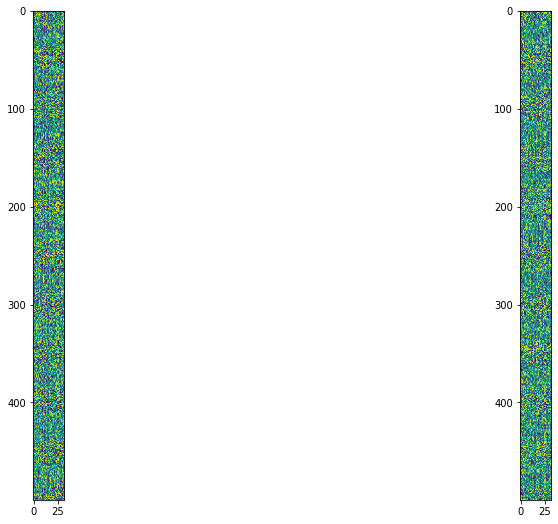

In [11]:
fig, axs = plt.subplots(1, 2)
# axs[0].imshow(cv2.cvtColor(des1, cv2.COLOR_BGR2RGB))
# axs[1].imshow(cv2.cvtColor(des2, cv2.COLOR_BGR2RGB))
axs[0].imshow(des1)
axs[1].imshow(des2)
plt.show()

In [12]:
# Type your answer below:
# 

- Given two ORB descriptors, how should you measure their distance?

In [13]:
# Type your answer below:
# 

Using `cv2.BFMatcher`, calculate the matching between the two lists of keypoints. Be sure to use the correct distance measurement. Also, set `crossCheck=True` when creating the matcher. After you get the matches, sort them by distance and call `cv2.drawMatches()` to display the 100 closest matches. You should see the following images (also found in 2.png):

![image-2.png](attachment:image-2.png)


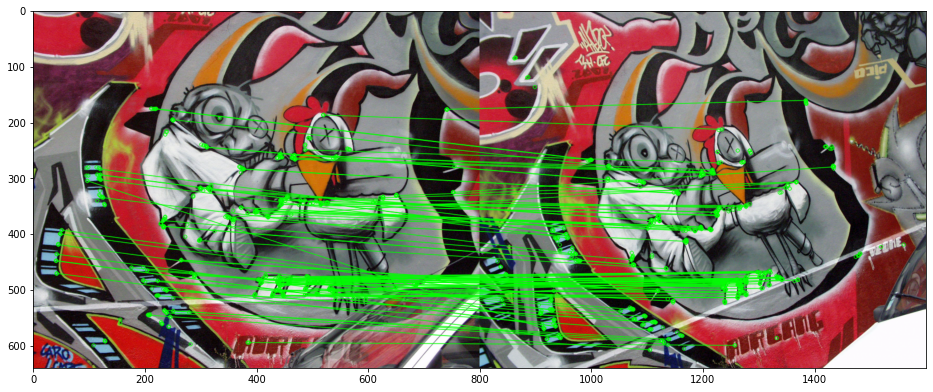

In [14]:
# create BFMatcher object
bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
# Match descriptors.
matches = bf.match(des1, des2)
# matches = cv2.BFMatcher(kps1, kps2)

# *************************************
# kps1, des1 = orb1.compute(img1, kp1)* => indices should correspond b/w
# kps2, des2 = orb2.compute(img2, kp2)* => kps1, kps2, des1, des2, and matches
# *************************************
match_img = cv2.drawMatches(img1, kps1, img2, kps2, matches[:100], None,
                            matchColor=(0,255,0), singlePointColor=(0,255,0))
plt.imshow(cv2.cvtColor(match_img, cv2.COLOR_BGR2RGB))
plt.show()

In [15]:
dist = []
for m in matches:
  dist.append(m.distance)

# for m in matches[:5]:
#   print(m)

# matches[0]
# do the indices in matches and kps1 and kps2 correspond??

In [16]:
dist.sort()

In [17]:
np.mean(dist) # use that as a thresh value for inliers

36.457142857142856

### 1c. Calculate Homography Between Matching Keypoints (20 points)

Implement the following function to calculate the projective transformation that maps a list of (x, y) coordinates `pts1` to the list of matching coordinates `pts2`. The return value is a 3x3 array representing the transformation matrix. You don't need to worry about there being outlier matches between `pts1` and `pts2` here.

You should implement this from from scratch and may **NOT** simply call functions from OpenCV or other libraries to solve this for you. 

In [18]:
def get_homography(pts_LCam, pts_RCam):
    """Estimate the affine transformation between two lists of matching
    keypoint coordinates.
    
    Args:
    - pts1: List of (x, y) coordinates.
    - pts2: List of (x, y) coordinates.
    
    Returns:
    - t: 3x3 array representing the projective 
         transformation matrix that maps `pts1` to `pts2`.
    """
    assert len(pts1) == len(pts2), \
        "`pts1` and `pts2` must have equal length."

    pts = np.array(pts_LCam)
    pts_prime = np.array(pts_RCam)

    A = []
    for i in range(len(pts)):
      a = np.hstack((pts[i][0], pts[i][1], 1, 0, 0, 0, -pts_prime[i][0]*pts[i][0], -pts_prime[i][0]*pts[i][1], -pts_prime[i][0]))
      A.append(a)
      b = np.hstack((0, 0, 0, pts[i][0], pts[i][1], 1, -pts_prime[i][1]*pts[i][0], -pts_prime[i][1]*pts[i][1], -pts_prime[i][1]))
      A.append(b)
    A = np.stack(A, axis=0)

    tmp = np.matmul(A.transpose(), A)
    eigval, eigvec = np.linalg.eigh(tmp)
    t = eigvec[:, 0].reshape(3, 3)
    t = (1/t.item(8)) * t

    return t

# Test the function on sample keypoints.
pts1 = [
    [313.9, 316.8],
    [120.0, 284.0],
    [437.2, 501.1],
    [221.0, 510.0],
]
pts2 = [
    [318.0, 372.0],
    [151.0, 390.0],
    [466.6, 504.0],
    [304.0, 571.0],
]

t = get_homography(pts1, pts2)
# is it possible to do decomposition on the homography (P or H) with RQ factorization?
# if so, we can get the intrinsic and extrinsic matrices K, R
# if so, we can use B = K^-T K^-1
print(t)

[[ 8.90373528e-01  3.14813867e-01 -4.22978981e+01]
 [-1.76637190e-01  9.37736253e-01  1.52508603e+02]
 [ 2.09320031e-04 -1.95635419e-05  1.00000000e+00]]


In [19]:
pts1 = [
    [313.9, 316.8],
    [120.0, 284.0],
    [437.2, 501.1],
    [221.0, 510.0],
]
pts2 = [
    [318.0, 372.0],
    [151.0, 390.0],
    [466.6, 504.0],
    [304.0, 571.0],
]

In [20]:
[p[1] for p in pts1]

[316.8, 284.0, 501.1, 510.0]

In [21]:
X = np.array(pts1)[:, 1]

In [22]:
# http://6.869.csail.mit.edu/fa12/lectures/lecture13ransac/lecture13ransac.pdf
# compute least squares/homography in parallel and also, 
# recompute least squares and homography with just the inliers
# https://rowannicholls.github.io/python/statistics/hypothesis_testing/multiple_linear_regression.html

# pts1 = [
#     [313.9, 316.8],
#     [120.0, 284.0],
#     [437.2, 501.1],
#     [221.0, 510.0],
# ]
# tmp = np.array(pts1)
# tmp[0][0]

### 1d. Estimate Affine Transformation Between Images Using RANSAC (30 points)

Implement the following function to estimate the homography between two images given keypoints and matches. There may be outliers in the keypoint matches and you should implement the RANSAC algorithm to reject them. You should implement RANSAC from scratch and may **NOT** simply call the corresponding functions in OpenCV or any other existing libraries.

In [23]:
print(len(kps1))
print(len(kps2))

kps1[0].pt

500
500


(397.0, 361.0)

In [24]:
# A = []
# for i in range(len(pts)):
#   a = np.hstack((pts[i][0], pts[i][1], 1, 0, 0, 0, -pts_prime[i][0]*pts[i][0], -pts_prime[i][0]*pts[i][1], -pts_prime[i][0]))
#   A.append(a)
#   b = np.hstack((0, 0, 0, pts[i][0], pts[i][1], 1, -pts_prime[i][1]*pts[i][0], -pts_prime[i][1]*pts[i][1], -pts_prime[i][1]))
#   A.append(b)
# A = np.stack(A, axis=0)

np.array([pts1[0], pts1[1], pts1[2]])

array([[313.9, 316.8],
       [120. , 284. ],
       [437.2, 501.1]])

In [25]:
test0 = []
test0.append(pts1[0])
test0.append(pts1[1])
test0.append(pts1[2])

test1 = np.array(test0)
test1

array([[313.9, 316.8],
       [120. , 284. ],
       [437.2, 501.1]])

In [26]:
import random

random.seed(1)
print(random.random())

0.13436424411240122


In [27]:
import random
from random import seed
from random import randint

pts1 = np.asarray([np.asarray(k.pt) for k in kps1])
pts2 = np.asarray([np.asarray(k.pt) for k in kps2])

for i in range(10):# select a subset of pts for each trial
  random.seed(i)
  # print(random.random())

  if i%2 == 0:
    randList = []
    for _ in range(50):# approx homography
      randIdx = randint(0, len(pts1))
      randList.append(randIdx)

    subset1 = [] 
    subset2 = []
    for r in randList:
      subset1.append(pts1[r])
      subset2.append(pts2[r])
    transf_mat = get_homography(subset1, subset2)
  else:
    randList = []
    img2pts = []
    for pred_samp in range(3):# apply homography for pred w/ 3 samples
      randIdx = randint(0, len(pts1))
      randList.append(randIdx)

    validation0 = []
    for r in randList:
      validation0.append(pts1[r])
      img2pts.append(pts2[r])
    valid1 = np.array(validation0)
    img2sub = np.array(img2pts)
    pred_img2 = transf_mat @ valid1
    print(pred_img2)
    print(abs(img2sub - pred_img2))

[[ 77268.32308739  64137.38603188]
 [103894.96925527  86240.98178016]
 [   210.68963419    174.88992254]]
[[7.67913231e+04 6.36283860e+04]
 [1.03729081e+05 8.58158937e+04]
 [4.22339174e+02 1.02806672e+02]]
[[3.87427763e+04 9.83306982e+04]
 [5.59586582e+04 1.42012559e+05]
 [1.18147266e+02 2.99835534e+02]]
[[3.83263762e+04 9.80450982e+04]
 [5.54177942e+04 1.41532175e+05]
 [3.27676770e+02 5.95885075e+01]]
[[5.44241846e+04 1.38716702e+05]
 [5.24277403e+04 1.33632621e+05]
 [1.15084812e+02 2.93326062e+02]]
[[5.38401206e+04 1.38552542e+05]
 [5.18433403e+04 1.33470621e+05]
 [6.11712157e+01 1.54571613e+02]]
[[170288.13353553  96720.7596132 ]
 [208830.01981172 118606.98686738]
 [   468.24133303    265.95591363]]
[[1.69913734e+05 9.63307596e+04]
 [2.08511117e+05 1.18237919e+05]
 [1.38241333e+02 3.28044086e+02]]
[[140095.29426351 131934.31490345]
 [184518.36807263 173772.0113148 ]
 [   383.40547857    361.06504566]]
[[1.39654654e+05 1.31436075e+05]
 [1.84041440e+05 1.73286443e+05]
 [5.34054786e+01

In [31]:
# sample 30 obs at a time
# distance from the best fit line is the inlier thresh

# first sample from the key pt sets
# the indices b/w sets correspond w/ each other 
# sample 30 observations at a time, then get best fit line
# use inlier_thresh to determine final linear model

def estimate_transformation_ransac(kps1, kps2, matches, transform_func,
                                   n_samples_homography, m_samples_pred, 
                                   n_trials, inlier_thresh):
  """
  Estimate the transformation between two matching lists of keypoints 
  using RANSAC.
  
  Args:
  - kps1: A list of `cv2.KeyPoint` objects.
  - kps2: A list of `cv2.KeyPoint` objects.
  - matches: A list of `cv2.DMatch` objects representing the matches
        between `kps1` and `kps2`.
  - transform_func: Function used to estimate the transformation given
        matching points.
  - n_samples: The number of samples in each RANSAC trial.
  - n_trials: The total number of RANSAC trials.
  - inlier_thresh: The threshold used to determine whether a match is an
        inlier or not.
  
  Returns:
  - transform: The 3x3 transformation matrix that maps kps1 to kps2.
  - mask: A list of Boolean values representing whether the corresponding
        match is an inlier or not.
  """
  import random
  from random import seed
  from random import randint

  pts1 = np.asarray([np.asarray(k.pt) for k in kps1])
  pts2 = np.asarray([np.asarray(k.pt) for k in kps2])

  # select a subset of pts for each trial
  for i in range(n_trials):# select a subset of pts for each trial
    random.seed(i)
    if i%2 == 0:
      randList = []
      for _ in range(n_samples_homography):# approx homography
        randIdx = randint(0, len(pts1))
        randList.append(randIdx)

      subset1 = [] 
      subset2 = []
      for r in randList:
        subset1.append(pts1[r])
        subset2.append(pts2[r])
      transf_mat = get_homography(subset1, subset2)
    else:
      randList = []
      img2pts = []
      for pred_samp in range(m_samples_pred):# apply homography for pred w/ 3 samples
        randIdx = randint(0, len(pts1))
        randList.append(randIdx)

      validation0 = []
      for r in randList:
        validation0.append(pts1[r])
        img2pts.append(pts2[r])
      valid1 = np.array(validation0)
      img2sub = np.array(img2pts)
      pred_img2 = transf_mat @ valid1
      print(pred_img2)
      print(abs(img2sub - pred_img2)) 

      # need to compute euclidean distance and 
      # the mask is the size of the image
      
      # max number of inliers given inlier threshold
      

  # return transf_mat#, mask
  return transf_mat, np.zeros((3, 3))

transform, mask = estimate_transformation_ransac(kps1, kps2, matches, get_homography, 100, 3, 5, 10)# last arg for inlier thresh
print(f"The transformation matrix:\n{transform}.")
# print(f"{np.sum(mask)} out of {len(matches)} matches are inliers.")


# RANSAC is just for inlier, residual/inlier screening before applying homography operation

[[ 79865.6736833   66297.13904762]
 [101528.29299436  84278.67234388]
 [   210.70796443    174.91102435]]
[[ 79388.6736833   65788.13904762]
 [101362.40497862  83853.58430067]
 [   422.32084416    102.78556989]]
[[4.29421294e+04 1.08989227e+05]
 [5.61027718e+04 1.42372358e+05]
 [1.18151561e+02 2.99838105e+02]]
[[4.25257294e+04 1.08703627e+05]
 [5.55619077e+04 1.41891974e+05]
 [3.27672474e+02 5.95859370e+01]]
The transformation matrix:
[[-2.90428003e-01 -7.00575756e-01  4.37268495e+02]
 [-2.83956233e-01 -7.53544588e-01  4.55052246e+02]
 [-6.39025983e-04 -1.62737734e-03  1.00000000e+00]].


In [32]:
# https://github.com/hughesj919/HomographyEstimation/blob/master/Homography.py
import random

def estimate_transformation_ransac(kps1, kps2, matches, n_samples, n_trials, inlier_thresh):
  keypoints = [kps1, kps2]
  matching_matrix = []
  for match in matches:
    x1, y1 = keypoints[0][match.queryIdx].pt
    x2, y2 = keypoints[1][match.trainIdx].pt
    matching_matrix.append([x1, y1, x2, y2])
    
  all_pts = np.matrix(matching_matrix)
  maxIns = []
  final_transform = None
  
  for i in range(n_trials):
    rdn_pts = []
    for i in range(n_samples):
      temp_row = all_pts[random.randrange(0, len(all_pts))]
      rdn_pts.append(temp_row)
          
    rn_pts = np.stack(rdn_pts, axis=0)
    pts1_rn = rn_pts[0:4, 0:2]
    pts2_rn = rn_pts[0:4, 2:4]
    
    t = get_homography(pts1_rn, pts2_rn)
      
    ins = []
    for i in range(len(all_pts)):
      p1 = np.transpose(np.matrix([all_pts[i].item(0), all_pts[i].item(1), 1]))
      pred_p2 = np.dot(t, p1)
      pred_p2 = (1/pred_p2.item(2))*pred_p2
      p2 = np.transpose(np.matrix([all_pts[i].item(2), all_pts[i].item(3), 1]))
    
      error = p2 - pred_p2
      d = np.linalg.norm(error)
        
      if d < inlier_thresh:
        ins.append(all_pts[i])
    if len(ins) > len(maxIns):
      maxIns = ins
      trans = t
    if len(maxIns) > (len(all_pts)*inlier_thresh):
      break

  return trans 

n_samples = 6
n_trials = 100
inlier_thresh = 10
transform = estimate_transformation_ransac(kps1, kps2, matches, n_samples, n_trials, inlier_thresh)
print(transform)

[[ 8.44118515e-01  2.58603094e-01 -2.07197395e+01]
 [-1.83006684e-01  8.66238741e-01  1.63171692e+02]
 [ 1.83250793e-04 -1.05961149e-04  1.00000000e+00]]


In [33]:
# https://medium.com/swlh/ds001-linear-regression-and-confidence-interval-a-hands-on-tutorial-760658632d99
# https://towardsdatascience.com/generating-confidence-intervals-for-regression-models-2dd60026fbce
# https://stackoverflow.com/questions/36400419/how-to-calculate-the-99-confidence-interval-for-the-slope-in-a-linear-regressio

def sm(lst):
  return np.sum(lst)

def func_as_param(tmp, zebra):
  res = zebra(tmp)
  return res

tmp = [1, 2, 3, 4, 5]
func_as_param(tmp, sm)

15

In [34]:
# https://en.wikipedia.org/wiki/Random_sample_consensus
from copy import copy
import numpy as np
from numpy.random import default_rng
rng = default_rng()

class RANSAC:
    def __init__(self, n=10, k=100, t=0.05, d=10, model=None, loss=None, metric=None):
      self.n = n              # `n`: Minimum number of data points to estimate parameters -- **no_samples**
      self.k = k              # `k`: Maximum iterations allowed -- **no_trials**
      self.t = t              # `t`: Threshold value to determine if points are fit well -- **inlier_thresh**
      self.d = d              # `d`: Number of close data points required to assert model fits well
      self.model = model      # `model`: class implementing `fit` and `predict` -- **transform_func**
      self.loss = loss        # `loss`: function of `y_true` and `y_pred` that returns a vector
      self.metric = metric    # `metric`: function of `y_true` and `y_pred` and returns a float
      self.best_fit = None
      self.best_error = np.inf

    def fit(self, X, y):
      for _ in range(self.k):
        ids = rng.permutation(X.shape[0])
        # print('ids:', ids, 'length of ids:', len(ids))    
        possib_inliers = ids[: self.n]
        # print('possible_inliers:', possib_inliers, 'length of possible_inliers:', len(possib_inliers))
        possib_model = copy(self.model).fit(X[possib_inliers], y[possib_inliers])

        thresholded = (
            self.loss(y[ids][self.n :], possib_model.predict(X[ids][self.n :]))
            < self.t
        )
        inlier_ids = ids[self.n :][np.flatnonzero(thresholded).flatten()]
        
        if inlier_ids.size > self.d:
          inlier_points = np.hstack([possib_inliers, inlier_ids])
          better_model = copy(self.model).fit(X[inlier_points], y[inlier_points])

          this_error = self.metric(
              y[inlier_points], better_model.predict(X[inlier_points])
          )

          if this_error < self.best_error:
            self.best_error = this_error
            self.best_fit = possib_model
      return self

    def predict(self, X):
        return self.best_fit.predict(X)


def square_error_loss(y_true, y_pred):
  return (y_true - y_pred) ** 2

def mean_square_error(y_true, y_pred):
  return np.sum(square_error_loss(y_true, y_pred)) / y_true.shape[0]


class LinearRegressor:
    def __init__(self):
      self.params = None
    
    def fit(self, X: np.ndarray, y: np.ndarray):
      r, _ = X.shape
      X = np.hstack([np.ones((r, 1)), X])
      self.params = np.linalg.inv(X.T @ X) @ X.T @ y
      # self.params = np.linalg.inv(X.T @ X) @ X.T @ y
      return self

    def predict(self, X: np.ndarray):
      r, _ = X.shape
      X = np.hstack([np.ones((r, 1)), X])
      return X @ self.params

    # def fit(self, X: np.ndarray, y: np.ndarray):
    #   r, _ = X.shape
    #   X = np.hstack([np.ones((r, 1)), X])
    #   # np.linalg.inv(A.T @ A) @ A.T @ b
    #   self.params = np.linalg.inv(X.T @ X) @ X.T @ y
    #   return self

69
69


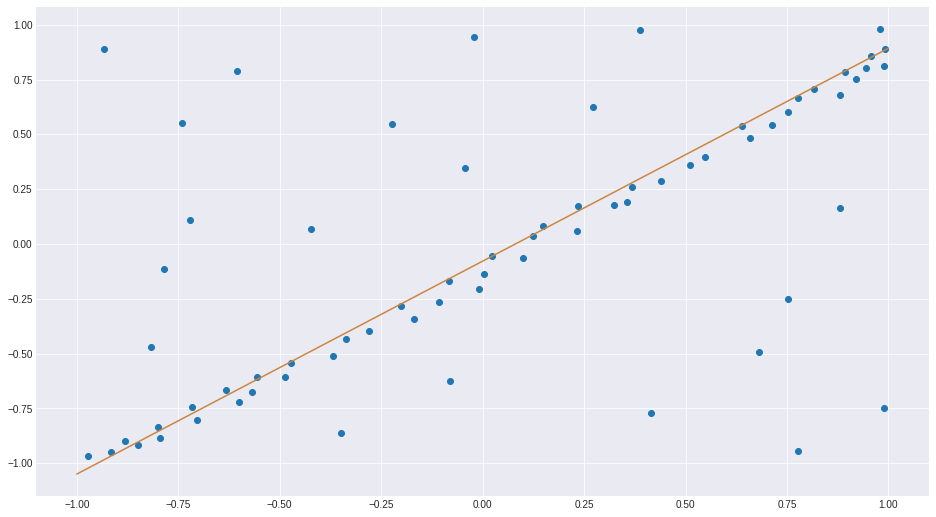

In [ ]:
if __name__ == "__main__":
  regressor = RANSAC(model=LinearRegressor(), loss=square_error_loss, metric=mean_square_error)

  A = np.array([-0.848,-0.800,-0.704,-0.632,-0.488,-0.472,-0.368,-0.336,-0.280,-0.200,-0.00800,
                -0.0840,0.0240,0.100,0.124,0.148,0.232,0.236,0.324,0.356,0.368,0.440,0.512,0.548,
                0.660,0.640,0.712,0.752,0.776,0.880,0.920,0.944,-0.108,-0.168,-0.720,-0.784,-0.224,
                -0.604,-0.740,-0.0440,0.388,-0.0200,0.752,0.416,-0.0800,-0.348,0.988,0.776,0.680,
                0.880,-0.816,-0.424,-0.932,0.272,-0.556,-0.568,-0.600,-0.716,-0.796,-0.880,-0.972,
                -0.916,0.816,0.892,0.956,0.980,0.988,0.992,0.00400]).reshape(-1,1)
  b = np.array([-0.917,-0.833,-0.801,-0.665,-0.605,-0.545,-0.509,-0.433,-0.397,-0.281,-0.205,-0.169,
                -0.0531,-0.0651,0.0349,0.0829,0.0589,0.175,0.179,0.191,0.259,0.287,0.359,0.395,0.483,
                0.539,0.543,0.603,0.667,0.679,0.751,0.803,-0.265,-0.341,0.111,-0.113,0.547,0.791,0.551,
                0.347,0.975,0.943,-0.249,-0.769,-0.625,-0.861,-0.749,-0.945,-0.493,0.163,-0.469,0.0669,
                0.891,0.623,-0.609,-0.677,-0.721,-0.745,-0.885,-0.897,-0.969,-0.949,0.707,0.783,0.859,
                0.979,0.811,0.891,-0.137]).reshape(-1,1)
  # print(len(A))
  # print(len(b))

  # pts1 = np.array([
  #   [313.9, 316.8],
  #   [120.0, 284.0],
  #   [437.2, 501.1],
  #   [221.0, 510.0],
  # ]).reshape(-1,1)
  # pts2 = np.array([
  #     [318.0, 372.0],
  #     [151.0, 390.0],
  #     [466.6, 504.0],
  #     [304.0, 571.0],
  # ]).reshape(-1,1)

  regressor.fit(A, b)
  plt.style.use("seaborn-darkgrid")
  fig, ax = plt.subplots(1, 1)
  # ax.set_box_aspect(1)

  plt.scatter(A, b)
  line = np.linspace(-1, 1, num=100).reshape(-1, 1)
  plt.plot(line, regressor.predict(line), c="peru")
  plt.show()

In [ ]:
# line
regressor.predict(line)[:5]

The following cell warps image 1 based on the estimated homography and displays the overlay of the aligned images. You should see the following image (also found 3.png):

![image.png](attachment:image.png)

In [ ]:
def stitch_images(img1, img2, transform):
    h1, w1 = img1.shape[:2]
    h2, w2 = img2.shape[:2]

    # Warp corners of image 1 to coordinates system of image 2.
    corners = np.array([
        [0., w1, w1, 0.],
        [0., 0., h1, h1],
        [1., 1., 1., 1.]
    ])
    new_corners = transform @ corners
    new_corners /= new_corners[2, :]
    # Calculate range of warped image 1.
    l = np.min(new_corners[0, :])
    r = np.max(new_corners[0, :])
    t = np.min(new_corners[1, :])
    b = np.max(new_corners[1, :])
    # Calculate size of the stitched image.
    l = np.min((l, 0))
    r = np.max((r, w2))
    t = np.min((t, 0))
    b = np.max((b, h2))
    w = int(np.round(r-l))
    h = int(np.round(b-t))
    # Calculate how much we should shift the stitched image.
    dx = max((-l, 0.))
    dy = max((-h, 0.))
    shift = np.array([
        [1., 0., dx],
        [0., 1., dy],
        [0., 0., 1.]
    ])

    # Warp input images and overlay them.
    warped_img1 = cv2.warpPerspective(img1, shift @ transform, (w, h))
    warped_img2 = cv2.warpPerspective(img2, shift, (w, h))
    overlayed_img = cv2.addWeighted(warped_img1, 0.5, warped_img2, 0.5, 0.0)
    return overlayed_img


stitched_img = stitch_images(img1, img2, transform)
plt.imshow(cv2.cvtColor(stitched_img, cv2.COLOR_BGR2RGB))
plt.show()

# 2. Disparity Map (30 points)

In this problem you will find dense correspondences between the stereo image pair below and calculate the disparity map. This will be done by doing template matching between image windows.

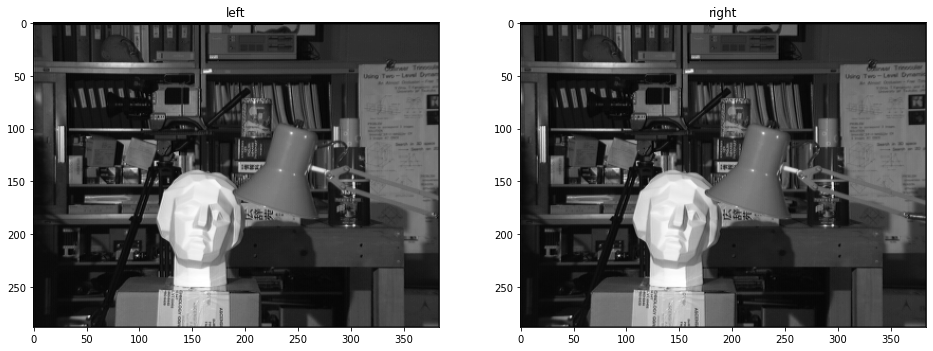

In [ ]:
img1 = cv2.imread('left.bmp')
img1 = cv2.cvtColor(img1, cv2.COLOR_BGRA2GRAY) / 255.

img2 = cv2.imread('right.bmp')
img2 = cv2.cvtColor(img2, cv2.COLOR_BGRA2GRAY) / 255.

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(img1, cmap='gray')
ax1.set_title('left')
ax2.imshow(img2, cmap='gray')
ax2.set_title('right')
plt.show()

In [ ]:
img2.shape

(288, 384)

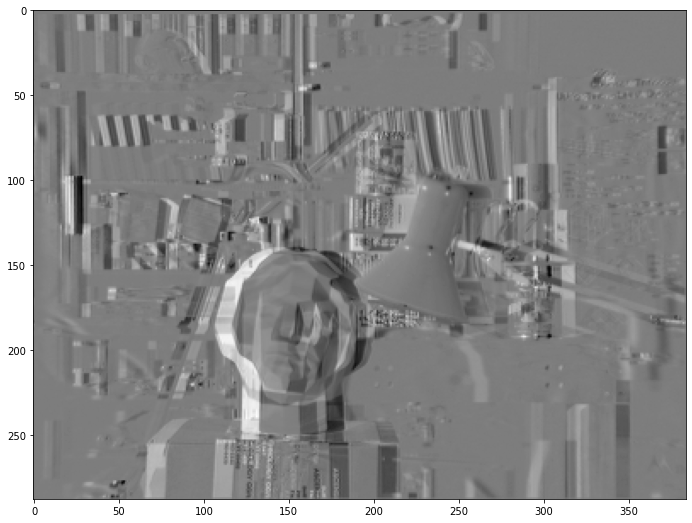

In [ ]:
img_diff = (img2 - img1)
plt.imshow(img_diff, cmap='gray')
plt.show()

In [ ]:
for i in range((img2 - img1).shape[0]):
  print((img2 - img1)[i].max()*100)

In [ ]:
img2.max()

0.9921568627450981

In [ ]:
# for i in range(img1.shape[0]):
#   print(np.sum((img1[i] - img2[i])**2))

In the cell below, implement a system to calculate the disparity map and visualize the results. You can assume that the camera angle of the images are already rectified, so the epipolar lines are all horizontal. Use SSD as the similarity measure between windows. Set the window size to `7` and the maximum disparity value to `40`.

A naive implementation could take several minutes to run and you should avoid that. Recall from the lectures that we covered a more efficient implementation. You should see the following image (also found in 4.png):

![image.png](attachment:image.png)


In [ ]:
# slide 31, module 6 QR factorization for KR, approx of intrinsic, extrinsic matrices
# note: extrinsic is rotation, translation between pix and world coord
# factorization is for 1 image
# slide 35, approx of B = K^-T K^-1, symm and pos def
# need at 4 pts per plane to compute homography

# https://www.youtube.com/watch?v=cA8K8dl-E6k
# supposed to match keypoints and refine keypoints 
# with ransac before image registration


from scipy.signal import convolve2d

assert img1.shape == img2.shape
h, w = img1.shape

dmin, dmax = 0, 40  # disparity search range
s = 7  # window size
disp = np.zeros(img2.shape)
# take templates of size 7 from img1 and convolve over img2
# convolve over just one row, compute SSD, save


plt.imshow(disp, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
# best = -np.ones(img1.shape)
# disp = np.zeros(img1.shape)
# for k in range(dmin, dmax):
#   prod = img1[:, :overlap] * img2[:, overlap+k]
#   CC = convolve2d(prod)
# 	better = CC > best
# 	disp = better * k + (1-better) * disp
# 	best = better * CC + (1-better) * best
################################################################################
# best = -ones(size(im))
# disp = zeros(size(im))
# for k = mindisparity:maxdisparity
# 	prod = I1(:,overlap) .* I2(:,k+overlap)
# 	CC = conv2(prod,fspecial(‘average’,winsize))
# 	better = CC > best;
# 	disp = better .* k + (1-better).*disp;
# 	best = better .*CC + (1-better).*best;
# end

In [ ]:
# https://pramod-atre.medium.com/disparity-map-computation-in-python-and-c-c8113c63d701

In [ ]:
def sum_of_sqr_diff(pixel_vals_1, pixel_vals_2):
  if pixel_vals_1.shape != pixel_vals_2.shape:
    return -1
  return np.sum((pixel_vals_1 - pixel_vals_2)**2)

In [ ]:
def compare_templates(i, j, block_left, right_array, window_size):
  SEARCH_BLOCK_SIZE = 20# max disparity size?
  j_min = max(0, j - SEARCH_BLOCK_SIZE)
  # print('j:', j, ' ', 'SEARCH_BLOCK_SIZE:', SEARCH_BLOCK_SIZE)
  # print('j - SEARCH_BLOCK_SIZE:', j - SEARCH_BLOCK_SIZE)
  # print('j_min:', j_min)
  j_max = min(right_array.shape[1], j + SEARCH_BLOCK_SIZE)
  first = True
  min_ssd = None
  min_index = None

  for j in range(j_min, j_max):
    block_right = right_array[i : i + window_size,
                              j : j + window_size]
    ssd = sum_of_sqr_diff(block_left, block_right)# block_left: 7x7, block_right: 
    if first:
      min_ssd = ssd
      # min_index = (i, j)
      min_index = j
      first = False
    else:
      if ssd < min_ssd:
        min_ssd = ssd
        min_index = j
        # min_index = (i, j)
  return min_index

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


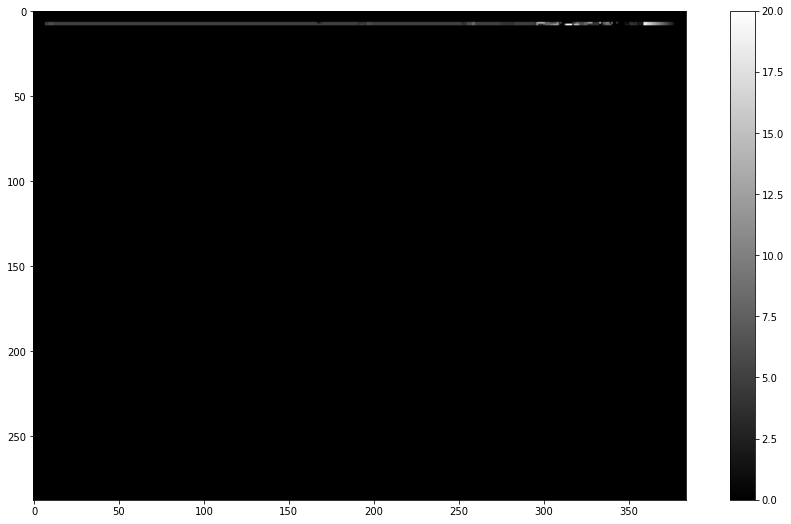

In [ ]:
assert img1.shape == img2.shape

h, w = img1.shape
im_left = np.asarray(img1)
im_right = np.asarray(img2)
window_size = 7
disparity_map = np.zeros((h, w))

count = 0
for i in range(window_size, h-window_size):
  count += 1
  if count > 2:
    break
  for j in range(window_size, w-window_size):
    # print('row:', i, 'row + window_size: ', i + window_size)
    # print('col:', j, 'col + window_size: ', j + window_size)
    template_left = im_left[i : i + window_size,
                            j : j + window_size]# always 7x7
    min_index = compare_templates(i, j, template_left, 
                                  im_right, window_size)
    # disparity_map[i, j] = abs(min_index[1] - j)
    disparity_map[i, j] = abs(min_index - j)

print(disparity_map)
plt.imshow(disparity_map, cmap='gray')
plt.colorbar()
plt.show()

In [ ]:
h, w = img1.shape
dmin, dmax = 0, 40  # disparity search range
s = 7  # window size

best = -np.ones(img1.shape[0])
disp = np.zeros(img1.shape[0])
for k in range(dmin, dmax):
  ssd = np.sum((img1[:, s] - img2[:, s+k])**2)
  better = ssd > best
  if k < 5:
    print(better)
  disp = better * k + (1-better) * disp
  best = better * ssd + (1-better) * best

In [ ]:
disp

array([16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16.,
       16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16., 16

In [ ]:
img1.shape

(288, 384)

In [ ]:
# best = -ones(size(im))
# disp = zeros(size(im))
# for k = mindisparity:maxdisparity
# 	prod = I1(:,overlap) .* I2(:,k+overlap)
# 	CC = conv2(prod,fspecial(‘average’,winsize))
# 	better = CC > best;
# 	disp = better * k + (1-better) * disp;
# 	best = better * CC + (1-better) * best;

In [ ]:
import scipy.signal

image = [[1, 2, 3, 4, 5, 6, 7],
         [8, 9, 10, 11, 12, 13, 14],
         [15, 16, 17, 18, 19, 20, 21],
         [22, 23, 24, 25, 26, 27, 28],
         [29, 30, 31, 32, 33, 34, 35],
         [36, 37, 38, 39, 40, 41, 42],
         [43, 44, 45, 46, 47, 48, 49]]

filter_kernel = [[-1, 1, -1],
                 [-2, 3, 1],
                 [2, -6, 0]]

res = scipy.signal.convolve2d(image, filter_kernel,
                              mode='same', boundary='fill', fillvalue=0)
print(res)

[[  -2   -8   -7   -6   -5   -4   28]
 [   3   -7  -10  -13  -16  -19   14]
 [ -18  -28  -31  -34  -37  -40    0]
 [ -39  -49  -52  -55  -58  -61  -14]
 [ -60  -70  -73  -76  -79  -82  -28]
 [ -81  -91  -94  -97 -100 -103  -42]
 [-101  -61  -63  -65  -67  -69  -57]]
